# 📡 Имитационное моделирование RFID системы без коллизий

В этом блокноте проводится **имитационное моделирование UHF RFID системы** с одним считывателем и одной меткой без коллизий. Рассматривается система, представленная в блокноте `3d_model_of_system`, то есть RFID считыватель закреплён на летящем равномерно и прямолинейно БПЛА над полем, на котором находится одна RFID метка. Движение происходит вдоль стены, из-за которой возникает явление многолучевого распространения сигнала, влияющее на уровень потерь в канале между считывателем и меткой.

Данный блокнот воспроизводит ключевые графики, ранее представленные в магистерской диссертации, а именно зависимость вероятности чтения пользовательского банка памяти (USER) метки от:
1) Скорости движения БПЛА со считывателем для разных M и Tari. Для данного эксперимента приводится 2 графика. Они отличаются расстоянием считывателя от стены;
2) Высоты полёта БПЛА со считывателем для разных расстояний БПЛА от стены, от которой происходит отражение сигнала;
3) Мощности считывателя в dBm для разных высот полёта БПЛА;
4) Длины пакета передаваемых данных от метки к считывателю. Здесь также приводится 2 графика. На одном изображены кривые для разных мощностей считывателя, а на другом кривые для разных M и Tari;
5) ... .


Так как запуск нескольких сетов имитационных RFID моделей (один сет - одна кривая на графике) занимает много времени (десятки минут), в данном блокноте предусмотрена возможность сохранения результатов моделирования в json-файлы. Тогда для построения графиков можно выбрать два варианта: использовать готовые данные из json-файла (быстро, но используются старые данные) или перезапустить модели и построить кривые на основе новых данных (ожидание десятки минут для хорошей статистической устойчивости результатов).


### Импорт необходимых модулей

In [1]:
import copy
import json
import numpy as np
import os

from tqdm import tqdm
from typing import Callable
import matplotlib.pyplot as plt

from pysim.experiments.utility.graphs_style import savefig, GraphConsts, setup_matplotlib
from pysim.models.rfid.cli import prepare_multiple_simulation
from pysim.models.rfid.constants import default_params, inner_params

In [2]:
JSON_DIRECTORY = 'result_jsons/rfid/'
IMAGE_DIRECTORY = 'rfid' # Директория для сохранения изображений
SAVE_FIG = True         # Сохранять ли изображения
SAVE_RESULTS = False     # Сохранять ли результаты в JSON
USE_JSON = False         # Использовать ли результаты из JSON

setup_matplotlib()

## Функции для запуска моделирования и построения графиков

In [3]:
def calculate_probs(
    variable: str,
    variable_values: list,
    params_list: list[dict],
    key_fn: Callable[[dict], str],
    use_json: bool = USE_JSON,
    save_results: bool = SAVE_RESULTS,
    file_name: str = "probs"
) -> dict[str, list[float]]:
    """
    Запуск нескольких сетов моделирования и получение зависимостей
    вероятности чтения от варьируемого параметра.

    Args:
        variable: имя переменной, в зависимости от которой исследуется вероятность;
        variable_values: список значений переменной variable (ось абсцисс);
        params_list: список параметров для разных кривых каждого сета моделирования;
        key_fn: функция, формирующая имя кривой по параметрам из params_list;
        use_json: если True, то попытаться загрузить результаты из JSON;
        save_results: если True, сохранить результаты в JSON;
        file_name: имя файла JSON.

    Returns:
        results: словарь, где ключ — имя кривой, значение — список вероятностей.
    """
    directory = JSON_DIRECTORY + file_name
    if use_json and os.path.exists(directory):
        with open(directory, 'r') as f:
            results = json.load(f)
    else:
        results = {}
        for params in tqdm(params_list, desc=f"Моделирование по переменной {variable}"):
            sim_results = prepare_multiple_simulation(variable, **{variable: variable_values}, **params)
            key = key_fn(params)
            results[key] = [res[0]['read_tid_prob'] for res in sim_results]

        if save_results:
            os.makedirs(os.path.dirname(directory), exist_ok=True)
            with open(directory, 'w') as f:
                json.dump(results, f, indent=2)
    return results

In [4]:
def plot_probs(
    results_list: list[dict[str, list[float]]],
    labels_list: list[str] | list[list[str]],
    titles: list[str],
    x_variable: list[float],
    x_label: str,
    y_label: str = "Вероятность чтения\nбанка памяти USER",
    unified_legend: bool = False,
    image_name: str = "Probs",
    save_fig: bool = SAVE_FIG
) -> None:
    """
    Универсальное построение графиков зависимости вероятности чтения
    от произвольного параметра.

    Args:
        results_list: список словарей с результатами;
        labels: ключи и подписи для легенд;
        titles: заголовки для подграфиков;
        x_values: значения variable для оси OX;
        x_label: подпись оси X;
        y_label: подпись оси Y;
        unified_legend: использовать ли одну легенду для обоих графиков
        image_name: имя файла;
        save_fig: сохранять ли картинку.
    """
    graphs_amount = len(results_list) # Количество графиков
    fig, axes = plt.subplots(figsize=(7 * graphs_amount, 5), ncols=graphs_amount)

    if graphs_amount == 1:
        axes = [axes]
        labels_list = [labels_list]

    graph_num = 0 # В случае использования одной легенды нужно считать построенные графики
    for ax, results, labels, title in zip(
        axes, results_list, labels_list, titles
    ):
        for key in labels:
            y_vals = results[key]
            ax.plot(x_variable, y_vals, label=key, marker='o')
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.grid()
        if not (unified_legend and graph_num >= 1):
            legend_pos = 0.5
            if unified_legend:
                legend_pos = 1
            ax.legend(
                loc="upper center",
                bbox_to_anchor=(legend_pos, -0.15),
                ncol=2,
            )
        graph_num += 1

    if save_fig:
        savefig(name=image_name, directory=IMAGE_DIRECTORY)

## 📈 Зависимость вероятности чтения банка памяти USER от скорости

Рассматриваются следующие варианты типов кодирования ответов метки (M) и длительности команд считывателя (Tari):
1) M = FM0, Tari = 6,26 мкс
2) M = FM0, Tari = 18,75 мкс
3) M = Miller-2, Tari = 12,5 мкс
4) M = Miller-4, Tari = 6,25 мкс
5) M = Miller-8, Tari = 25 мкс

### ⚙️ Параметры для запуска моделирования

In [5]:
# Переменная по оси абсцисс
speed_variable = np.arange(5.0, 72.5, 2.5)
# Параметры для разных кривых
coding_params = [
    {'encoding': 'FM0', 'tari': 6.25},
    {'encoding': 'FM0', 'tari': 18.75},
    {'encoding': 'M2', 'tari': 12.5},
    {'encoding': 'M4', 'tari': 6.25},
    {'encoding': 'M8', 'tari': 25.0},
]

# Каждый словарь в list - это набор входных данных для одной кривой
# --- Данные для первого графика ---
speed_params_list = []
for coding_params_item in coding_params:
    speed_params_list.append({
        'tari': coding_params_item['tari'],
        'encoding': coding_params_item['encoding'],
        'tid_word_size': default_params.tid_word_size,
        'power': default_params.power_dbm,
         # 'num_tags': default_params.num_tags,
        'num_tags': 50,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': default_params.altitude,
        'useadjust': default_params.useadjust,
        'delta': default_params.delta,
    })

# --- Данные для второго графика ---
new_reader_offset = 1.0
speed_params_list_2 = []
for params in speed_params_list:
    new_params = copy.deepcopy(params)
    new_params['reader_offset'] = new_reader_offset
    speed_params_list_2.append(new_params)

### 💾 Получение результатов

In [6]:
key_name = lambda params: f"M = {params['encoding']}, Tari = {params['tari']} мкс"

In [7]:
# --- Первый график ---
speed_result = calculate_probs(
    variable="speed",
    variable_values=speed_variable,
    params_list=speed_params_list,
    key_fn=key_name,
    use_json=True,
    save_results=SAVE_RESULTS,
    file_name="speed.json"
)
# Моделирование на M3 Pro с 'num_tags': 2000:
# Моделирование по скоростям: 100%|██████████| 5/5 [41:43<00:00, 500.79s/it]

In [8]:
# --- Второй график ---
speed_result_2 = calculate_probs(
    variable="speed",
    variable_values=speed_variable,
    params_list=speed_params_list_2,
    key_fn=key_name,
    use_json=True,
    save_results=SAVE_RESULTS,
    file_name="speed_2.json"
)
# Моделирование на M3 Pro с 'num_tags': 250:
# Моделирование по переменной speed: 100%|██████████| 5/5 [05:35<00:00, 67.12s/it] 

### 🖼️ Построение графика

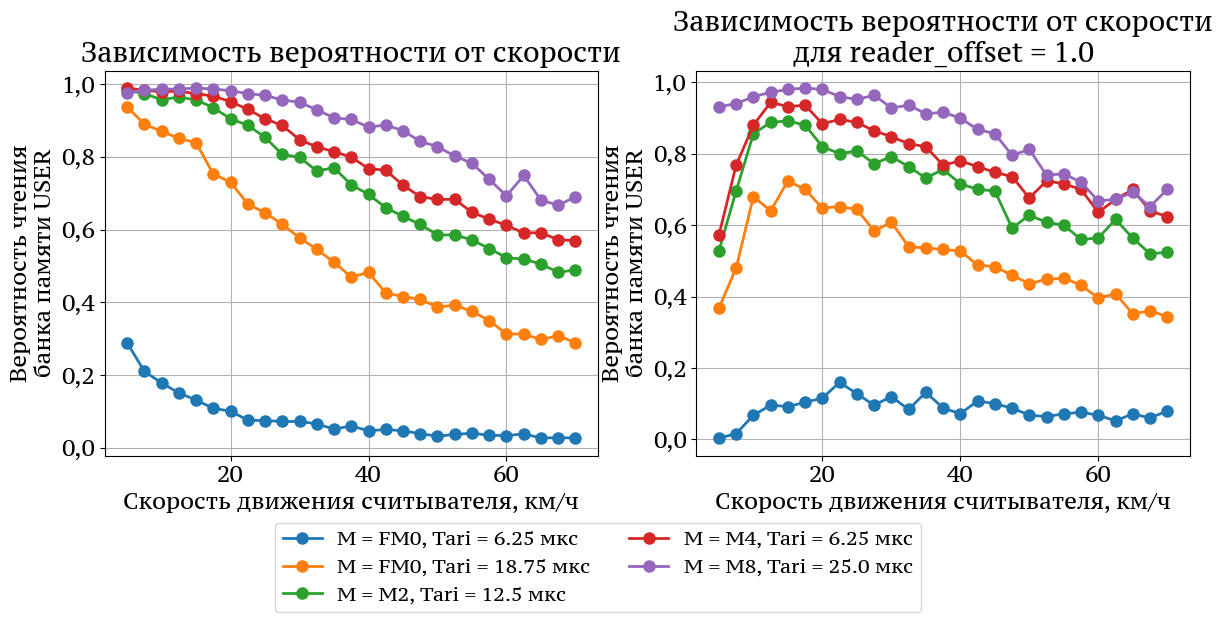

In [9]:
plot_probs(
    results_list=[speed_result, speed_result_2],
    labels_list=[
    [key_name(params) for params in coding_params],
    [key_name(params) for params in coding_params]
    ],
    titles=[
        "Зависимость вероятности от скорости",
        f"Зависимость вероятности от скорости\nдля reader_offset = {new_reader_offset}"
    ],
    x_variable=speed_variable,
    x_label="Скорость движения считывателя, км/ч",
    unified_legend=True,
    image_name="Speed probs",
    save_fig=True
)

## 📈 Зависимость вероятности чтения банка памяти USER от высоты полёта считывателя
Рассматриваются следующие варианты расстояний БПЛА со считывателем от стены
1) 0,5 м
2) 1 м
3) 1,5 м
4) 2 м
5) 2,5 м
6) 3 м

### ⚙️ Параметры для запуска моделирования

In [10]:
# Переменная по оси абсцисс
altitudes = np.arange(0.5, 7.5, 0.5)
# Параметры для разных кривых
offset_params = [
    {'reader_offset': 0.5},
    {'reader_offset': 1},
    {'reader_offset': 1.5},
    {'reader_offset': 2},
    {'reader_offset': 2.5},
    {'reader_offset': 3},
]

altitude_params_list = []
for offset_params_item in offset_params:
    altitude_params_list.append({
        'tari': default_params.tari,
        'encoding': default_params.encoding,
        'tid_word_size': default_params.tid_word_size,
        'power': default_params.power_dbm,
        # 'num_tags': default_params.num_tags,
        'num_tags': 5,
        'speed': default_params.speed,
        'reader_offset': offset_params_item['reader_offset'],
        'tag_offset': default_params.tag_offset,
        'useadjust': default_params.useadjust,
        'delta': default_params.delta,
    })

### 💾 Получение результатов

In [11]:
key_name = lambda params: f"Расстояние от стены = {params['reader_offset']} м"

In [12]:
altitude_results = calculate_probs(
    variable="altitude",
    variable_values=altitudes,
    params_list=altitude_params_list,
    key_fn=key_name,
    use_json=True,
    save_results=False,
    file_name='altitude.json'
)
# Моделирование на M3 Pro с 'num_tags': 500:
# Моделирование по высоте: 100%|██████████| 6/6 [06:08<00:00, 61.39s/it]

### 🖼️ Построение графика

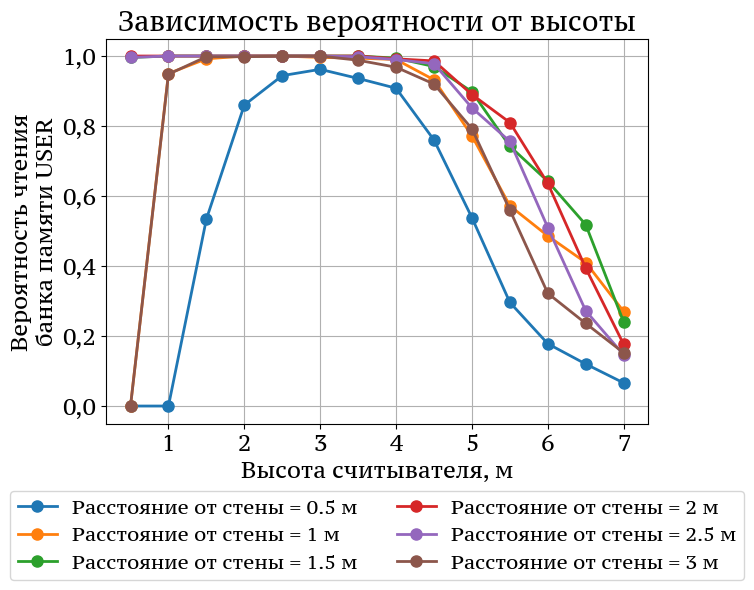

In [13]:
plot_probs(
    results_list=[altitude_results],
    labels_list=[key_name(params) for params in offset_params],
    titles=["Зависимость вероятности от высоты"],
    x_variable=altitudes,
    x_label="Высота считывателя, м",
    image_name="Altitude probs",
    save_fig=False
)

## 📈 Зависимость вероятности чтения банка памяти USER от мощности считывателя
Рассматриваются следующие варианты высоты полёта БПЛА со считывателем:
1) 1 м
2) 3 м
3) 5 м
4) 7 м

### ⚙️ Параметры для запуска моделирования

In [14]:
# Переменная по оси абсцисс
powers = np.arange(19.0, 32.0, 0.5)
# Параметры для разных кривых
altitude_params = [
    {'altitude': 1},
    {'altitude': 3},
    {'altitude': 5},
    {'altitude': 7},
]

power_params_list = []
for alt in altitude_params:
    power_params_list.append({
        'tari': default_params.tari,
        'encoding': default_params.encoding,
        'tid_word_size': default_params.tid_word_size,
        # 'num_tags': default_params.num_tags,
        'num_tags': 50,
        'speed': default_params.speed,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': alt['altitude'],
        'useadjust': default_params.useadjust,
        'delta': default_params.delta,
    })

### 💾 Получение результатов

In [15]:
key_name = lambda params: f"Высота полёта = {params['altitude']} м"

In [16]:
power_results = calculate_probs(
    variable='power',
    variable_values=powers,
    params_list=power_params_list,
    key_fn=key_name,
    use_json=True,
    save_results=False,
    file_name="power.json"
)
# Моделирование на M3 Pro с 'num_tags': 750:
# Моделирование по мощности: 100%|██████████| 4/4 [09:42<00:00, 145.58s/it]

### 🖼️ Построение графика

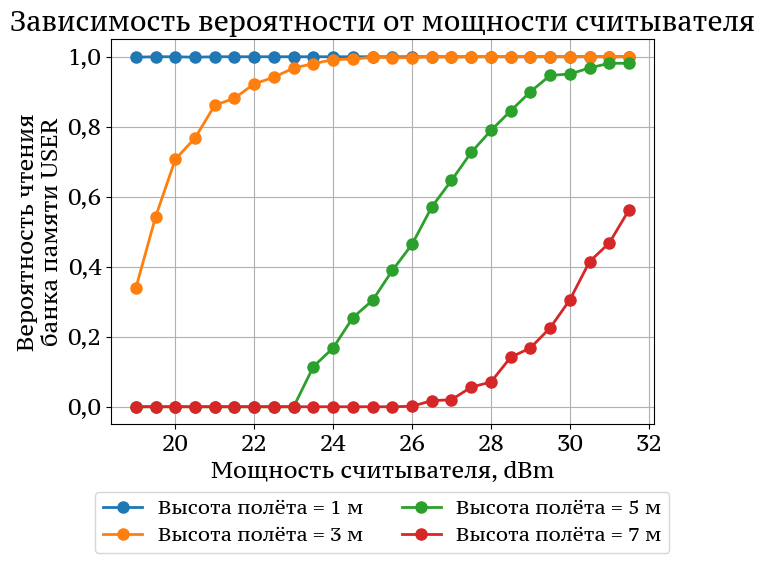

In [17]:
plot_probs(
    results_list=[power_results],
    labels_list=[key_name(p) for p in altitude_params],
    titles=["Зависимость вероятности от мощности считывателя"],
    x_variable=powers,
    x_label="Мощность считывателя, dBm",
    image_name="Power probs",
    save_fig=False
)

## 📈 Зависимость вероятности чтения банка памяти USER от величины банка USER
#### В данном случае проводится 2 серии экспериментов:
В первой серии экспериментов строится серия кривых. Каждая кривая получается для разной мощности передатчика считывателя.Рассматриваются следующие варианты мощности:
1) 27 dBm
2) 29 dBm
3) 31,5 dBm

Во второй серии экспериментов рассматриваются кривые для разных пар Tari и M:
1) M = FM0, Tari = 6,26 мкс
2) M = FM0, Tari = 18,75 мкс
3) M = Miller-2, Tari = 12,5 мкс
4) M = Miller-4, Tari = 6,25 мкс
5) M = Miller-8, Tari = 25 мкс

### ⚙️ Параметры для запуска моделирования

In [18]:
tid_lengths = list(range(16, 257, 16))  # от 16 до 256 с шагом 16
# Для первой серии экспериментов ------------------------------------
power_params = [
    {'power': 27},
    {'power': 29},
    {'power': 31.5},
]

length_params_list_1_exp = []
for power in power_params:
    length_params_list_1_exp.append({
        'tari': default_params.tari,
        'encoding': default_params.encoding,
        'power': power['power'],
        # 'num_tags': default_params.num_tags,
        'num_tags': 40,
        'speed': default_params.speed,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': default_params.altitude,
        'useadjust': default_params.useadjust,
        'delta': default_params.delta,
    })

In [19]:
# Для второй серии экспериментов ------------------------------------
coding_params = [
    {'encoding': 'FM0', 'tari': 6.25},
    {'encoding': 'FM0', 'tari': 18.75},
    {'encoding': 'M2', 'tari': 12.5},
    {'encoding': 'M4', 'tari': 6.25},
    {'encoding': 'M8', 'tari': 25.0},
]

length_params_list_2_exp = []
for coding_params_item in coding_params:
    length_params_list_2_exp.append({
        'tari': coding_params_item['tari'],
        'encoding': coding_params_item['encoding'],
        'power': default_params.power_dbm,
        # 'num_tags': default_params.num_tags,
        'num_tags': 250,
        'speed': default_params.speed,
        'reader_offset': default_params.reader_offset,
        'tag_offset': default_params.tag_offset,
        'altitude': default_params.altitude,
        'useadjust': default_params.useadjust,
        'delta': default_params.delta,
    })

### 💾 Получение результатов

In [20]:
key_name = lambda params: f"Мощность = {params['power']} дБм"
key_name_2 = lambda params: f"M = {params['encoding']}, Tari = {params['tari']} мкс"

In [21]:
length_results_1_exp = calculate_probs(
    variable="tid_word_size",
    variable_values=tid_lengths,
    params_list=length_params_list_1_exp,
    key_fn=key_name,
    use_json=True,
    save_results=False,
    file_name="length_1.json"
)
# Моделирование на M3 Pro с 'num_tags': 1000:
# Моделирование по длине пакета: 100%|██████████| 3/3 [04:56<00:00, 98.89s/it] 

In [22]:
length_results_2_exp = calculate_probs(
    variable="tid_word_size",
    variable_values=tid_lengths,
    params_list=length_params_list_2_exp,
    key_fn=key_name_2,
    use_json=True,
    save_results=False,
    file_name="length_2.json"
)

### 🖼️ Построение графика

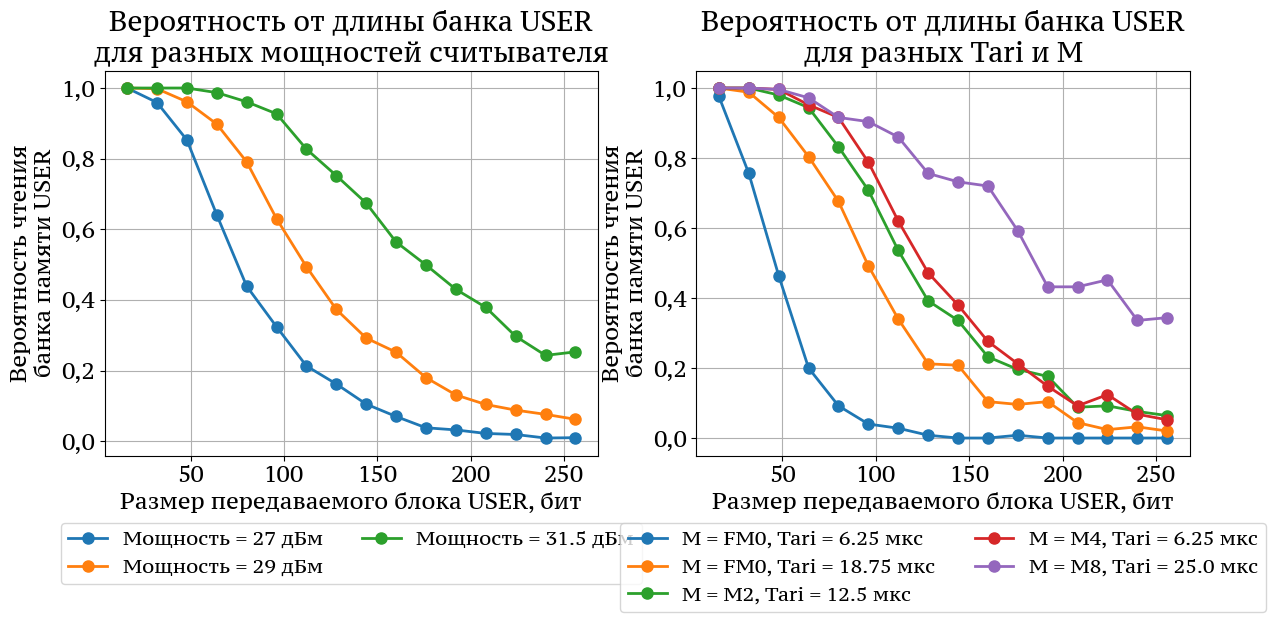

In [23]:
plot_probs(
    results_list=[length_results_1_exp, length_results_2_exp],
    labels_list=[
        [key_name(params) for params in power_params],
        [key_name_2(params) for params in coding_params],
    ],
    titles=[
        "Вероятность от длины банка USER\nдля разных мощностей считывателя",
        "Вероятность от длины банка USER\nдля разных Tari и M"
    ],
    x_variable=tid_lengths,
    x_label="Размер передаваемого блока USER, бит",
    image_name="Length probs",
    save_fig=False
)

## 📈 Зависимость вероятности чтения банка памяти USER от расстояния метки от стены

### ⚙️ Параметры для запуска моделирования

In [104]:
# Значения переменной по оси абсцисс
tag_offsets = np.arange(1.0, 4.0, 0.25)  # от 0.25 до 2.75 с шагом 0.25

# Разные высоты полёта БПЛА
altitude_params = [
    {'altitude': 1.0},
    {'altitude': 2.0},
    {'altitude': 3.0},
]

tag_offset_params_list = []
for alt in altitude_params:
    tag_offset_params_list.append({
        'tari': default_params.tari,
        'encoding': default_params.encoding,
        # 'tid_word_size': default_params.tid_word_size,
        'tid_word_size': 176,
        # 'power': default_params.power_dbm,
        'power': 27,
        'num_tags': 50,
        'speed': 60.0,
        'reader_offset': 2.5,
        'altitude': alt['altitude'],
        'useadjust': default_params.useadjust,
        'delta': default_params.delta,
    })

### 💾 Получение результатов

In [105]:
key_fn = lambda params: f"Высота = {params['altitude']} м"

In [106]:
tag_offset_results = calculate_probs(
    variable="tag_offset",
    variable_values=tag_offsets,
    params_list=tag_offset_params_list,
    key_fn=key_fn,
    use_json=False,
    save_results=True,
    file_name="tag_offset.json"
)

Моделирование по переменной tag_offset: 100%|██████████| 3/3 [00:16<00:00,  5.49s/it]


### 🖼️ Построение графика

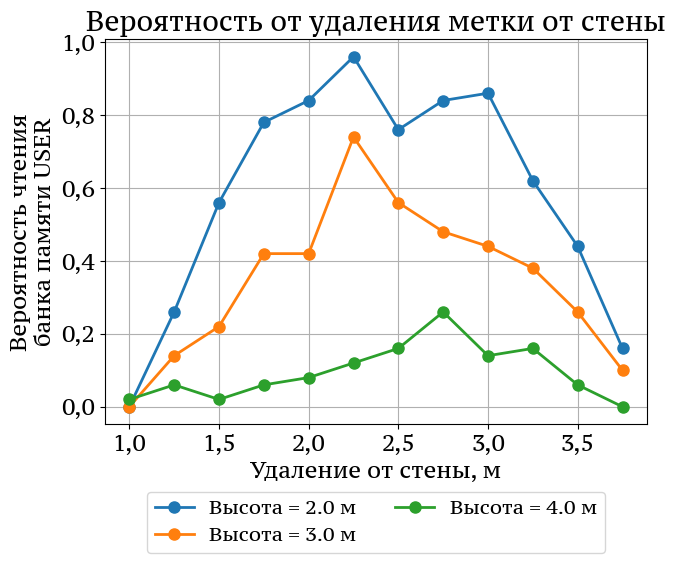

In [103]:
plot_probs(
    results_list=[tag_offset_results],
    labels_list=[key_fn(p) for p in altitude_params],
    titles=["Вероятность от удаления метки от стены"],
    x_variable=tag_offsets,
    x_label="Удаление от стены, м",
    image_name="Tag offset probs",
    save_fig=True
)

In [63]:
tag_offset_results

{'Высота = 1.0 м': [0.0, 0.0, 0.18, 0.7, 0.96, 1.0, 0.98, 1.0, 1.0, 1.0, 0.94],
 'Высота = 2.0 м': [0.1, 0.4, 0.76, 0.92, 0.98, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0],
 'Высота = 3.0 м': [0.38,
  0.56,
  0.7,
  0.8,
  0.92,
  0.94,
  0.94,
  0.98,
  1.0,
  0.94,
  0.94]}